# Exercise 06: The Stommel problem

**Due:** _2 February 2021_

**Names:** Mariana, Linus, Lukas, David  

Consider the vorticity equation for a linear, flat bottom, barotropic, viscid ocean
in steady state on an mid-latitude beta plane, forced by a zonally uniform zonal
wind stress
\begin{equation}
  \gamma\nabla^2\psi + \beta\frac{\partial \psi}{\partial x}
  = -\frac{\partial}{\partial y}\left(\frac{\tau^x}{\rho_0 H}\right)
\end{equation}
where $\psi$ is the stream function of the vertically averaged velocity $u$ and
$v$, i.e. $\psi_x = v$ and $\psi_y = -u$, $\gamma$ is the damping time scale,
$\beta = \frac{\partial f}{\partial y}$, $\rho_0$ is a reference density, $H$ is the depth of the Ocean and $\tau^x$ is the zonal wind stress.

Take $H=5000\,m$, $\rho_0=1000\,kg\,m^{-3}$, $\gamma = 0.1\,days^{-1}$ and
$\beta = 2\cdot10^{-11}\,m^{-1}s^{-1}$. The size of the basin is $L_x = 10000\,km$
in the zonal direction and $L_y = 4000\,km$ in the meridional direction. The wind
stress is given by $\tau^x = \tau_0 \sin(\pi \frac{y - y_0}{L_y})$ with
$\tau_0 = 0.01\,Nm^{-2}$ and $y_0$ is the central latitude of the domain.

1. Discretize the domain with a grid spacing of $dx = dy = 50\,km$.
  Solve the Stommel problem using centred differences with the Jacobi method,
  the Gauss-Seidel method and Successive Over-relaxation. The boundary condition
  is $\psi=0$ at all boundaries. (7 points)

1. Investigate the convergence behavior of the three methods. (2 points)

1. Test the sensitivity of the convergence behavior of the SOR method to
  the value of the relaxation parameter $\omega$. (1 point)


## 1. Discretizing the Stommel problem:
Centered differences for all spatial derivatives yields

\begin{equation}
\gamma \left( \frac{\psi_{i+1,j}-2\psi_{i,j}+\psi_{i-1,j}}{(\Delta x)^2} + \frac{\psi_{i,j+1}-2\psi_{i,j}+\psi_{i,j-1}}{(\Delta y)^2} \right) + \beta \frac{\psi_{i+1,j}-\psi_{i-1,j}}{2 \Delta x} = F_{i,j}
\end{equation}

were $F_{i,j}$ is the analytically computed and then discretized wind forcing term on the right-hand-side of the equation, namely

\begin{equation}
F_{i,j} = -\frac{\tau_{0}}{\rho_{0} H}\frac{\pi}{L_{y}} \cos \left( \pi \frac{y_{i,j}-y_{0}}{L_{y}} \right)
\end{equation}

Solving for $\psi_{i,j}$ with $\Delta x = \Delta y$ yields

\begin{equation}
\psi_{i,j} = \frac{1}{4}\left(\left( 1+ \frac{\beta \Delta x}{2 \gamma} \right) \psi_{i+1,j} + \left(1 - \frac{\beta \Delta x}{2 \gamma} \right)\psi_{i-1,j} +  \psi_{i,j+1} + \psi_{i,j-1} -\frac{(\Delta x)^2}{\gamma}F_{i,j} \right)
\end{equation}

In [63]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

In [64]:
class Stommel:
    def __init__(self, params = None):
        if params is None:
            params  = {'H': 5000., 'rho_0': 1000., 'gamma': 0.1/(24*3600), 'beta': 2e-11, 'omega': 1.25, 'Lx': 10000e3, 
                       'Ly': 4000e3, 'tau_0': 0.01, 'y_0': 2000e3, 'dxy': 50e3}
        self.H      = params['H']                               #m
        self.rho_0  = params['rho_0']                           #kg m⁻³ 
        self.gamma  = params['gamma']                           #s⁻¹
        self.beta   = params['beta']                            #m⁻¹ s⁻¹
        self.omega  = params['omega']                           # unitless
        self.Lx     = params['Lx']                              #m
        self.Ly     = params['Ly']                              #m
        self.tau_0  = params['tau_0']                           #N m⁻²
        self.y_0    = params['y_0']                             #m
        self.dxy    = params['dxy']                             #m
        self.key_dict()                                         #sets keyword arguments to switch between methods
        self.set_grid()                                         #m
        self.set_forcing()                                      #s⁻²
        self.psi_init     = np.zeros(self.F.shape)              #initial streamfunction is chosen by the shape of the forcing after first iteration
        

    def key_dict(self):
        self.method_dict = {'Jacobi': self.jacobi,'Gauss-Seidel': self.gauss_seidel,'SOR': self.sor}
        
    def set_grid(self):
        """
        Needs to be re-run if grid parameters are changed.
        """
        self.grid_x  = np.arange(0,self.Lx+self.dxy,self.dxy)   
        self.grid_y  = np.arange(0,self.Ly+self.dxy,self.dxy)
        self.mesh_y, self.mesh_x = np.meshgrid(self.grid_y, self.grid_x)
        
    def set_forcing(self):
        """
        Precomputed wind forcing. Make sure, the grid is set before the forcing. Units are in 1/s^2!
        """
        self.F = -self.tau_0*np.pi*np.cos(np.pi*(self.mesh_y-self.y_0)/self.Ly)/self.rho_0/self.H/self.Ly
    
    def iterate(self,tol=1e-6, method='Jacobi'):
        """
        Computes the iterations of the given scheme until the difference between two iterations is smaller than the given tolerance.
        """
        #initialize the iterations of the while loop
        scheme  = self.method_dict[method]
        psi_old = np.copy(self.psi_init)
        psi_new = scheme(psi_old)
        convergence     = np.amax(abs(psi_new-psi_old))
        self.dpsi       = [convergence] 
        
        while(convergence >= tol):
            psi_old = np.copy(psi_new)
            psi_new = scheme(psi_old)
            convergence = np.amax(abs(psi_new-psi_old))
            self.dpsi.append(convergence)
            
            #include break statement in case the solutions are diverging
            if self.dpsi[-1] >= self.dpsi[-2]:
                break
            
        self.psi = psi_new 
        
    def jacobi(self,psi_old):
        """
        One iteration of the Jacobi method. The streamfunction is computed index wise.
        """
        psi_new = np.zeros(psi_old.shape)
        for i in range(1,len(self.grid_x)-1):
            for j in range(1,len(self.grid_y)-1):
                psi_new[i,j] = 0.25*((1+self.beta*self.dxy/(2*self.gamma))*psi_old[i+1,j]+(1-self.beta*self.dxy/(2*self.gamma))*psi_old[i-1,j]
                                         +psi_old[i,j+1]+psi_old[i,j-1]-self.F[i,j]*(self.dxy**2)/self.gamma
                                     )
        return(psi_new)
        
    def gauss_seidel(self,psi_old):
        """
        One iteration of the Gauss-Seidel method. The streamfunction is computed index wise.
        """
        psi_new = np.zeros(psi_old.shape)
        for i in range(1,len(self.grid_x)-1):
            for j in range(1,len(self.grid_y)-1):
                psi_new[i,j] = 0.25*((1+self.beta*self.dxy/(2*self.gamma))*psi_old[i+1,j]+(1-self.beta*self.dxy/(2*self.gamma))*psi_new[i-1,j]
                                         +psi_old[i,j+1]+psi_new[i,j-1]-self.F[i,j]*(self.dxy**2)/self.gamma
                                     )
        return(psi_new)
    
    def sor(self,psi_old):
        """
        One iteration of the Successive Over Relaxation (SOR) method. The streamfunction is a linear combination of the previous iteration and the solution
        of the Gauss-Seidel method.
        """
        psi_ast = self.gauss_seidel(psi_old)
        psi_new = (1-self.omega)*psi_old + self.omega*psi_ast
        return(psi_new)
    
    def plot_psi(self):
        plt.figure(figsize=(20,10))
        plt.contourf(self.mesh_x/1000,self.mesh_y/1000,self.psi,levels=20,cmap='Blues')
        plt.xlabel('x in km')
        plt.ylabel('y in km')
        plt.colorbar(label = r'$\Psi$ in $\frac{m^{2}}{s}$')    

In [65]:
psi = Stommel()

### 1.1 Jacobi method

In [66]:
psi.iterate(method='Jacobi')
jacobi_iters = psi.dpsi

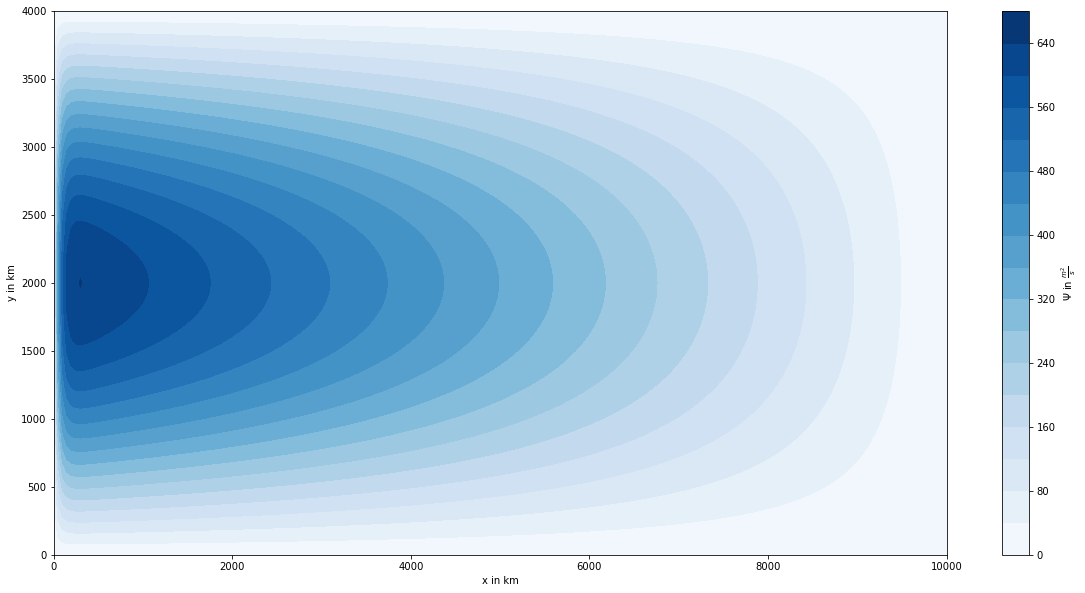

In [67]:
psi.plot_psi()

### 1.2 Gauss-Seidel method

In [68]:
psi.iterate(method='Gauss-Seidel')
gauss_seidel_iters = psi.dpsi

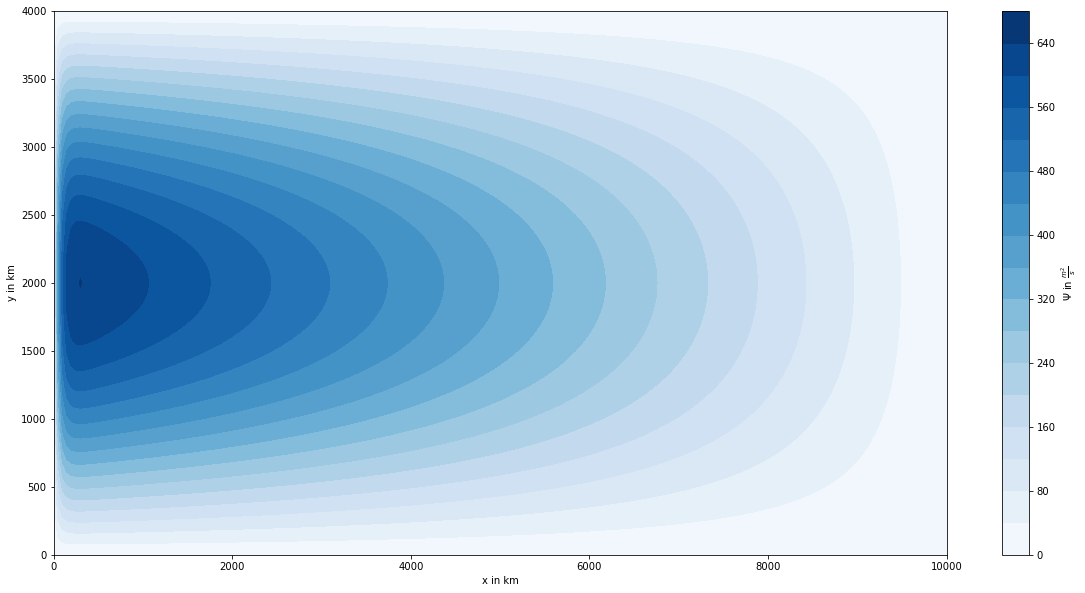

In [69]:
psi.plot_psi()

### 1.3 Successive Over Relaxation method 

In [70]:
psi.iterate(method='SOR')
sor_iters = psi.dpsi

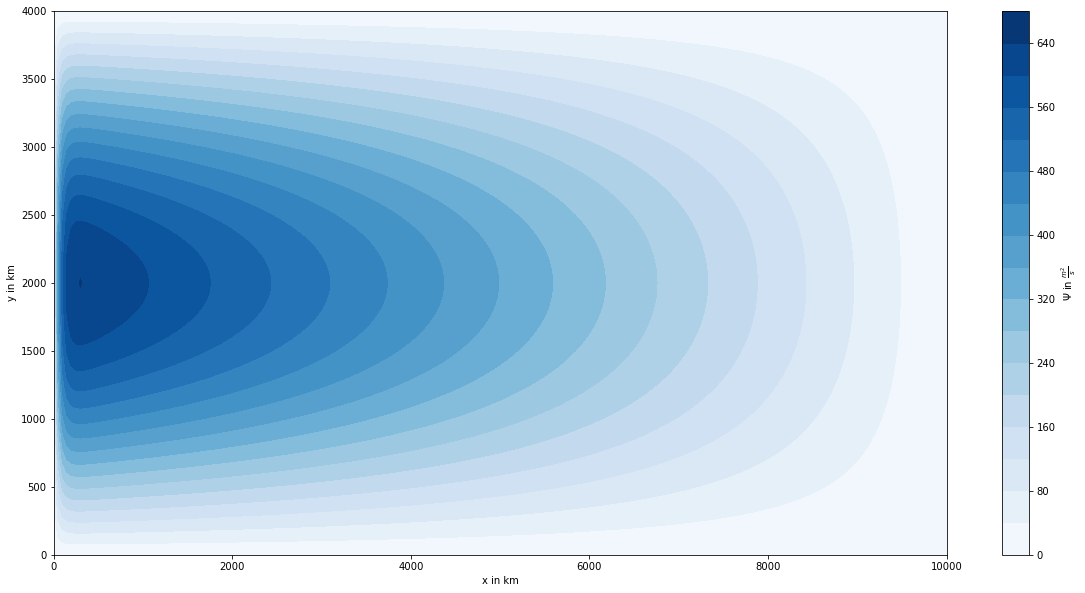

In [71]:
psi.plot_psi()

## 2.) Convergence behaviour

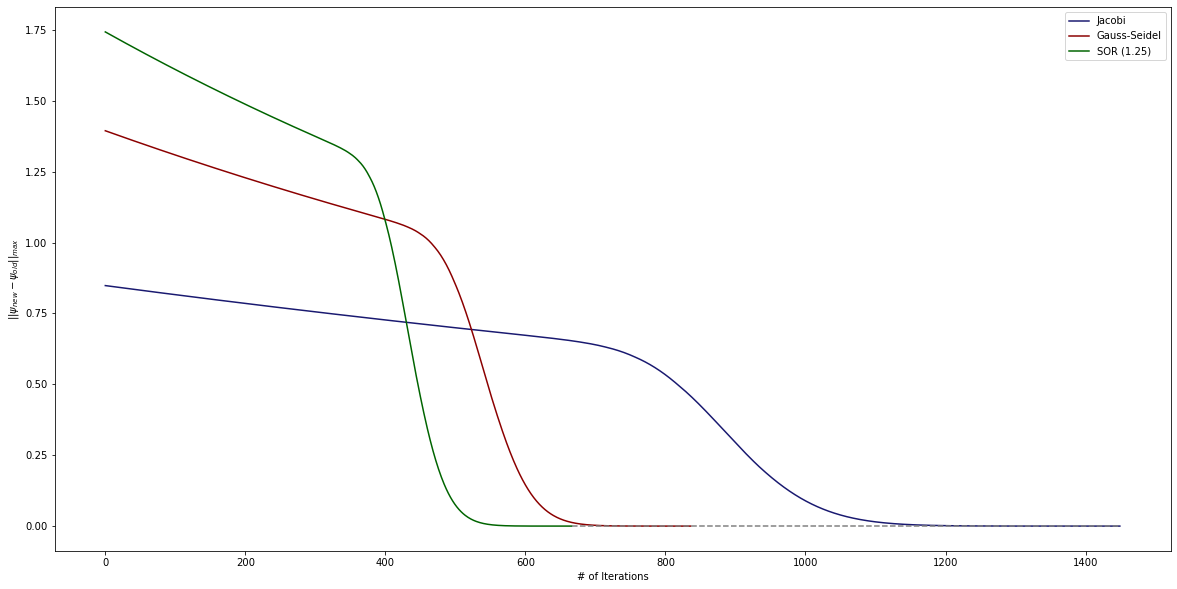

In [73]:
#get the number of iterations of the fastest converging method
min_index  = min(len(jacobi_iters),len(gauss_seidel_iters),len(sor_iters))
max_index  = max(len(jacobi_iters),len(gauss_seidel_iters),len(sor_iters))
converged  = np.arange(min_index,max_index)
iterations = np.arange(0,min_index)

#plotting the convergence using the maximumsnorm
plt.figure(figsize=(20,10))
plt.plot(jacobi_iters,label = 'Jacobi', color = 'midnightblue')
plt.plot(gauss_seidel_iters,label = 'Gauss-Seidel', color = 'darkred')
plt.plot(sor_iters,label = 'SOR (1.25)', color = 'darkgreen')
plt.plot(converged, np.zeros(converged.shape), linestyle='--', color = 'grey')
plt.xlabel('# of Iterations')
plt.ylabel(r'$||\psi_{new}-\psi_{old}||_{max}$')
plt.legend()

As visible in exercise 1.) all methods lead to the same stremfunction and are thus able to solve the stommel problem. However, the chosen method has a major impact on the number of iterations needed to reach the given tolerance. The convergence study above shows this. With well above 1400 iterations, the jacobi method is the slowest of the presented three. The Gauss-Seidel method only takes above 800 iterations. The fastest convergence behaviour can be seen when the Gauss-Seidel method is improved by Successive Over Relaxation - well below 700 iterations. The relaxation parameter $\omega$ is chosen with the results from the sensitivity study below. 

## 3.) Sensitivity with resprect to $\omega$

In [22]:
omegas = np.arange(0.5,2.6,0.1)
n_iter = []
for omega in omegas:
    psi.omega = omega
    psi.iterate(method='SOR')
    n_iter.append(psi.dpsi)

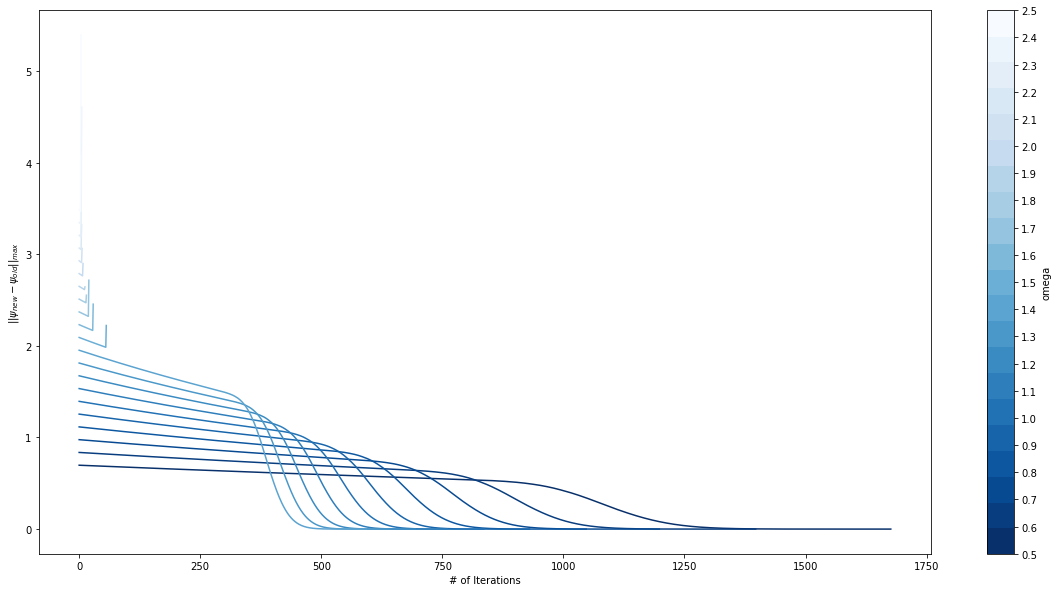

In [55]:
#Plotting
cmap = plt.get_cmap('Blues_r', len(omegas)) 

plt.figure(figsize=(20,10))
for i in range(0,len(omegas)):
    plt.plot(n_iter[i], c=cmap(i))
plt.xlabel('# of Iterations')
plt.ylabel(r'$||\psi_{new}-\psi_{old}||_{max}$')
# creating ScalarMappable for the colorbar
norm = mpl.colors.Normalize(vmin=0.5, vmax=2.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
sm.set_array([]) 
  
plt.colorbar(sm, ticks=omegas, label = 'omega') 

This plot shows the convergence behaviour of the SOR method, when choosing different values for the relaxation parameter $\omega$. As shown, the method converges faster for increasing values of $\omega$. After a critical value (~1.4) the algorithm gets unstable - the difference in the streamfunctions increases with iterations. Since the iteration function has a break criterium should this happen, the solutions stop so abruptly. The first value for $\omega$ where the method gets unstable can thus be seen more clearly in the graph below, where the number of iterations suddenly drops. 

In [58]:
converged = []
for i in range(0,len(omegas)):
    converged.append(len(n_iter[i]))

Text(0, 0.5, '# of iterations until convergence or stopping of algorithm')

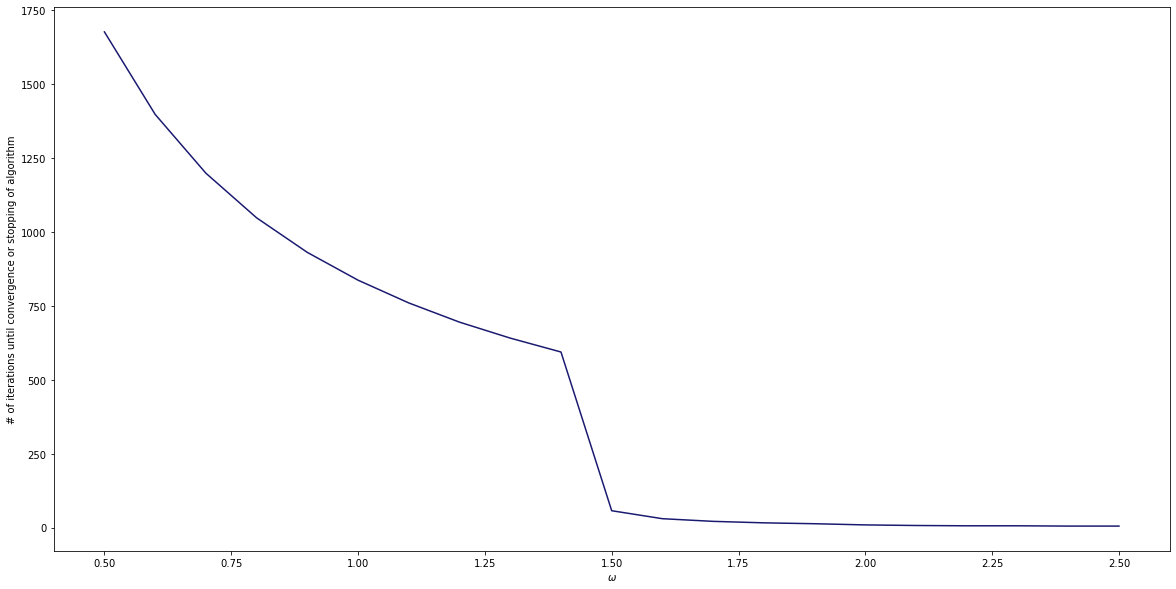

In [62]:
plt.figure(figsize=(20,10))
plt.plot(omegas, converged, color='midnightblue')
plt.xlabel(r'$\omega$')
plt.ylabel('# of iterations until convergence or stopping of algorithm')

For values above $\omega = 1.4$ the SOR method collapses.